# **Deteksi Serangan DDOS dengan Support Vector Machine**

## **Data Input**


### Import Library yang dibutuhkan

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
import pickle
import os

### Membaca dataset

In [3]:
dataset = pd.read_csv("data/dataset_ISCX.csv", low_memory=False)
dataset = dataset.dropna()
dataset.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Pembersihan nama kolom pada dataset

In [4]:
dataset.columns = dataset.columns.str.strip()
dataset.columns = dataset.columns.str.replace(" ", "_")


### Distribusi Data Setiap Kelas

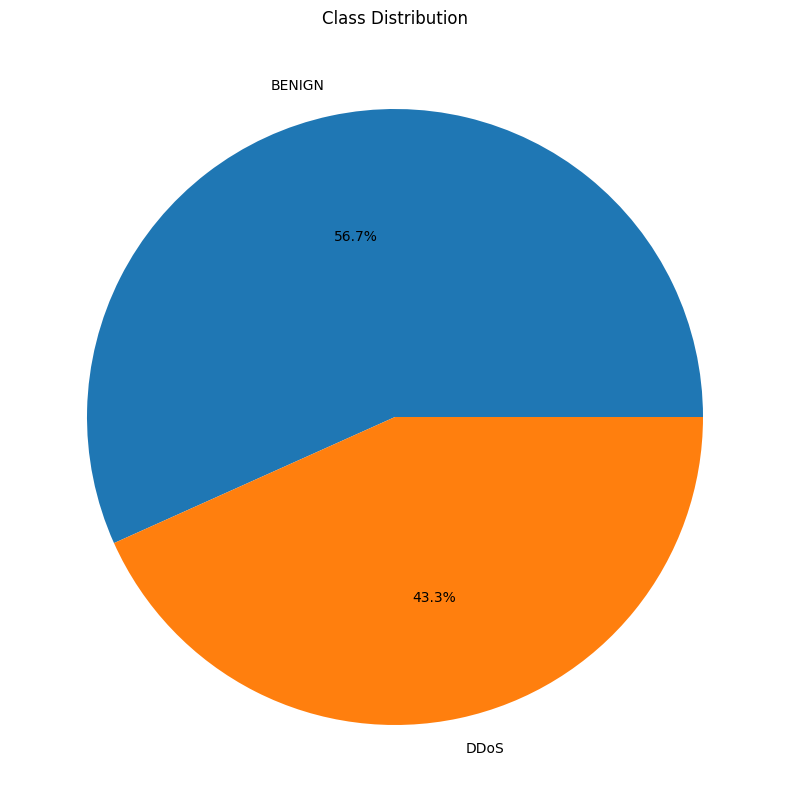

In [5]:
label = dataset["Label"].unique()
label_count = dataset["Label"].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(label_count, labels=label, autopct="%1.1f%%")
plt.title("Class Distribution")
plt.show()

## **Data Preprocessing**

### Merubah data kategorikal menjadi numerik

In [6]:
labelencoder = LabelEncoder()
labelencoder.fit(dataset["Label"])
dataset["Label"] = labelencoder.transform(dataset["Label"])

### Menghapus Fitur yang memiliki nilai bukan float64 ataupun infinity

In [7]:
dataset = dataset.drop(
    [
        "Timestamp",
        "Source_IP",
        "Destination_IP",
        "Flow_ID",
        "Flow_Bytes/s",
        "Flow_Packets/s",
    ],
    axis=1,
)
dataset = dataset.astype("float64")
dataset

,Source_Port,Destination_Port,Protocol,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,443.0,54865.0,6.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80.0,55054.0,6.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,80.0,55055.0,6.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,443.0,46236.0,6.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,443.0,54863.0,6.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,80.0,61374.0,6.0,61.0,1.0,1.0,6.0,6.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225741,80.0,61378.0,6.0,72.0,1.0,1.0,6.0,6.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225742,80.0,61375.0,6.0,75.0,1.0,1.0,6.0,6.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225743,80.0,61323.0,6.0,48.0,2.0,0.0,12.0,0.0,6.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Menampilkan Fitur yang tersedia

In [8]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 225741 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Source_Port                  225741 non-null  float64
 1   Destination_Port             225741 non-null  float64
 2   Protocol                     225741 non-null  float64
 3   Flow_Duration                225741 non-null  float64
 4   Total_Fwd_Packets            225741 non-null  float64
 5   Total_Backward_Packets       225741 non-null  float64
 6   Total_Length_of_Fwd_Packets  225741 non-null  float64
 7   Total_Length_of_Bwd_Packets  225741 non-null  float64
 8   Fwd_Packet_Length_Max        225741 non-null  float64
 9   Fwd_Packet_Length_Min        225741 non-null  float64
 10  Fwd_Packet_Length_Mean       225741 non-null  float64
 11  Fwd_Packet_Length_Std        225741 non-null  float64
 12  Bwd_Packet_Length_Max        225741 non-null  float64
 13  Bwd_

### Scaling Data

Scalling menggunakan MinMaxScalling dengan formula :

![MinMaxFormula](https://img-blog.csdnimg.cn/20201127162915978.png)

In [9]:
X = dataset.drop(["Label"], axis=1)
y = dataset["Label"]
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

### Feature Selection

In [10]:
XBest = SelectKBest(chi2, k=8).fit_transform(X, y)
XBest = pd.DataFrame(XBest)
XBest.columns = dataset.columns[1:9]
XBest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225741 entries, 0 to 225740
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination_Port             225741 non-null  float64
 1   Protocol                     225741 non-null  float64
 2   Flow_Duration                225741 non-null  float64
 3   Total_Fwd_Packets            225741 non-null  float64
 4   Total_Backward_Packets       225741 non-null  float64
 5   Total_Length_of_Fwd_Packets  225741 non-null  float64
 6   Total_Length_of_Bwd_Packets  225741 non-null  float64
 7   Fwd_Packet_Length_Max        225741 non-null  float64
dtypes: float64(8)
memory usage: 13.8 MB


## **Data Spliting**

In [11]:
train_X, test_X, train_y, test_y = train_test_split(XBest, y, test_size=0.2, random_state=42)

## **Model Training**

In [12]:
model = SVC()
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

## **Model Evaluation**

### Classification Report

In [13]:
print("Classification Report: \n", classification_report(test_y, pred_y, target_names=["Benign", "DDoS"]))

Classification Report: 
               precision    recall  f1-score   support

      Benign       1.00      0.93      0.96     19417
        DDoS       0.95      1.00      0.97     25732

    accuracy                           0.97     45149
   macro avg       0.97      0.96      0.97     45149
weighted avg       0.97      0.97      0.97     45149



### Visualise confusion matrix matplotlib


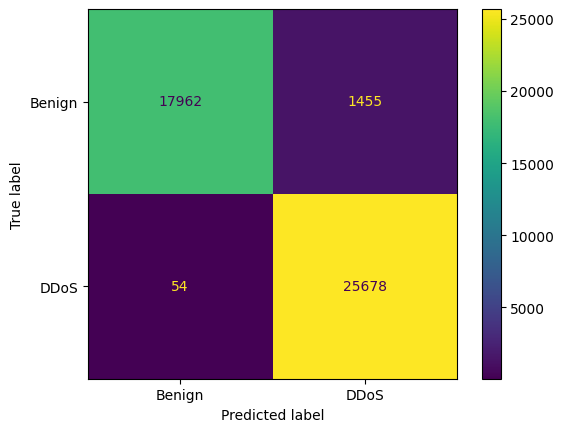

In [14]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_y, pred_y), display_labels=["Benign", "DDoS"])
cm_display.plot()

## **Export Model**

In [15]:
if not os.path.exists("model"):
    os.mkdir("model")
filename ="model/svm.pkl"
pickle.dump(model, open(filename, 'wb'))